In [1]:
# To support both python 2 and python 3
# 让这份笔记同步支持 python 2 和 python 3
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
#使用statsmodels便于统计分析数据
import statsmodels.api as sm
import statsmodels.formula.api as smf
#使用sklearn便于预测（机器学习）
from sklearn import linear_model
#使用patsy便于生成模型
import patsy

**11. This question uses the Caravan data set.
(a) Create a training set consisting of the first 1,000 observations,
and a test set consisting of the remaining observations.**

In [3]:
Caravan = pd.read_csv("data/Caravan.csv").dropna().drop('Unnamed: 0',axis = 1)
Caravan.head()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,No
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,No
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,No
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,No
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,No


In [4]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(Caravan, train_size = 1000, random_state = 1)

**(b) Fit a boosting model to the training set with Purchase as the
response and the other variables as predictors. Use 1,000 trees,
and a shrinkage value of 0.01. Which predictors appear to be
the most important?**

In [5]:
columns = '1'
for column in Caravan.columns:
    columns = columns + '+' + column
y_test,X_test = patsy.dmatrices('Purchase ~ {} - Purchase'.format(columns), test_set, return_type = 'dataframe')
y_train,X_train = patsy.dmatrices('Purchase ~ {} - Purchase'.format(columns), train_set, return_type = 'dataframe')
X_test.drop('Intercept',axis = 1,inplace= True)
X_train.drop('Intercept',axis = 1,inplace= True)

In [6]:
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(n_estimators = 1000,learning_rate=0.01,random_state = 1)
gb_clf.fit(X_train,y_train['Purchase[Yes]'])
#为了方便后面的AUC计算
gb_socres = gb_clf.decision_function(X_test)
feature_importance=pd.DataFrame({'feature':X_train.columns, 'importance':(gb_clf.feature_importances_ * 100).round(3)})
feature_importance.sort_values('importance',ascending=False).iloc[:10]

,feature,importance
46,PPERSAUT,6.025
7,MGODOV,5.975
82,AFIETS,5.860
67,APERSAUT,5.473
22,MBERARBG,3.941
21,MBERMIDD,3.350
81,APLEZIER,3.329
60,PPLEZIER,3.291
63,PBYSTAND,2.796
27,MSKC,2.609


**(c) Use the boosting model to predict the response on the test data.
Predict that a person will make a purchase if the estimated prob-
ability of purchase is greater than 20%. Form a confusion ma-
trix. What fraction of the people predicted to make a purchase
do in fact make one? How does this compare with the results
obtained from applying KNN or logistic regression to this data
set?**

In [7]:
from sklearn.metrics import confusion_matrix
gb_clf_predict =(gb_clf.predict_proba(X_test) > 0.2)[:,1]
#python生成的是[['TN','FP']['FN','TP']],与R互倒
gb_pred_table = pd.DataFrame(confusion_matrix(y_test['Purchase[Yes]'],gb_clf_predict).T,
                             index = ['No','Yes'],
                             columns = [['Purchase.test','Purchase.test'],['No','Yes']])
gb_pred_table.columns.names = ['','gb.pred']
gb_pred_table 

Purchase.test     
gb.pred            No  Yes
No               4291  241
Yes               242   48

In [8]:
# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train,y_train['Purchase[Yes]'])
#为了方便后面的AUC计算
lda_socres = lda.decision_function(X_test)
lda_predict =(lda.predict_proba(X_test) > 0.2)[:,1]
#python生成的是[['TN','FP']['FN','TP']],与R互倒
lda_pred_table = pd.DataFrame(confusion_matrix(y_test['Purchase[Yes]'],lda_predict).T,
                             index = ['No','Yes'],
                             columns = [['Purchase.test','Purchase.test'],['No','Yes']])
lda_pred_table.columns.names = ['','lda.pred']
lda_pred_table 

Purchase.test     
lda.pred            No  Yes
No                4324  242
Yes                209   47

In [9]:
# QDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X_train,y_train['Purchase[Yes]'])
#为了方便后面的AUC计算
qda_socres = qda.decision_function(X_test)
qda_predict =(qda.predict_proba(X_test) > 0.2)[:,1]
#python生成的是[['TN','FP']['FN','TP']],与R互倒
qda_pred_table = pd.DataFrame(confusion_matrix(y_test['Purchase[Yes]'],qda_predict).T,
                             index = ['No','Yes'],
                             columns = [['Purchase.test','Purchase.test'],['No','Yes']])
qda_pred_table.columns.names = ['','qda.pred']
qda_pred_table 

c:\users\wujiaxu\appdata\local\programs\python\python37\lib\site-packages\sklearn\discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Purchase.test     
qda.pred            No  Yes
No                4505  278
Yes                 28   11

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
knn = KNeighborsClassifier()
param_grid = [
{'n_neighbors': list(range(1,20))},
]
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train,y_train['Purchase[Yes]'])
grid_search.best_params_

{'n_neighbors': 4}

In [11]:
knn_predict =(grid_search.predict_proba(X_test) > 0.2)[:,1]
#python生成的是[['TN','FP']['FN','TP']],与R互倒
knn_pred_table = pd.DataFrame(confusion_matrix(y_test['Purchase[Yes]'],knn_predict).T,
                             index = ['No','Yes'],
                             columns = [['Purchase.test','Purchase.test'],['No','Yes']])
knn_pred_table.columns.names = ['','knn.pred']
knn_pred_table 

Purchase.test     
knn.pred            No  Yes
No                3622  187
Yes                911  102

In [12]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(solver='liblinear')
log.fit(X_train,y_train['Purchase[Yes]'])
log_socres = log.decision_function(X_test)
log_predict =(log.predict_proba(X_test) > 0.2)[:,1]
#python生成的是[['TN','FP']['FN','TP']],与R互倒
log_pred_table = pd.DataFrame(confusion_matrix(y_test['Purchase[Yes]'],log_predict).T,
                             index = ['No','Yes'],
                             columns = [['Purchase.test','Purchase.test'],['No','Yes']])
log_pred_table.columns.names = ['','logist.pred']
log_pred_table 

Purchase.test     
logist.pred            No  Yes
No                   4243  229
Yes                   290   60

In [13]:
confusion_matrix(y_test['Purchase[Yes]'],log_predict)[0,1]

290

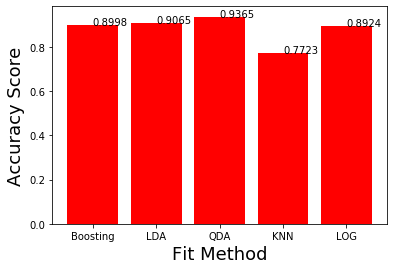

In [14]:
#比较各种算法的accucy
from sklearn.metrics import accuracy_score
accuracy_gb = accuracy_score(y_test['Purchase[Yes]'],gb_clf_predict)
accuracy_lda = accuracy_score(y_test['Purchase[Yes]'],lda_predict)
accuracy_qda = accuracy_score(y_test['Purchase[Yes]'],qda_predict)
accuracy_knn = accuracy_score(y_test['Purchase[Yes]'],knn_predict)
accuracy_log = accuracy_score(y_test['Purchase[Yes]'],log_predict)
method_list = ['Boosting','LDA','QDA','KNN','LOG']
accuracy_list = [accuracy_gb,accuracy_lda,accuracy_qda,accuracy_knn,accuracy_log]
plt.bar(method_list,accuracy_list,color = 'red')
for num in range(len(method_list)):
    plt.text(num,accuracy_list[num],accuracy_list[num].round(4))
plt.xlabel("Fit Method", fontsize=18)
plt.ylabel("Accuracy Score", fontsize=18)
plt.show()

对于精度而言，QDA最好，BOOSTING在LDA与LOG之间非常接近，KNN较差

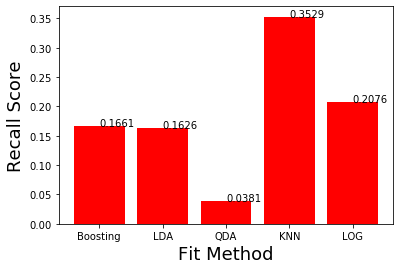

In [15]:
#recall召回率比较
from sklearn.metrics import recall_score
recall_gb = recall_score(y_test['Purchase[Yes]'],gb_clf_predict)
recall_lda = recall_score(y_test['Purchase[Yes]'],lda_predict)
recall_qda = recall_score(y_test['Purchase[Yes]'],qda_predict)
recall_knn = recall_score(y_test['Purchase[Yes]'],knn_predict)
recall_log = recall_score(y_test['Purchase[Yes]'],log_predict)
method_list = ['Boosting','LDA','QDA','KNN','LOG']
recall_list = [recall_gb,recall_lda,recall_qda,recall_knn,recall_log]
plt.bar(method_list,recall_list,color = 'red')
for num in range(len(method_list)):
    plt.text(num,recall_list[num],recall_list[num].round(4))
plt.xlabel("Fit Method", fontsize=18)
plt.ylabel("Recall Score", fontsize=18)
plt.show()

但从召回率上看KNN最好（如果是寻找推销目标，则KNN有其有利性，针对本题特意概率设置为0.2）

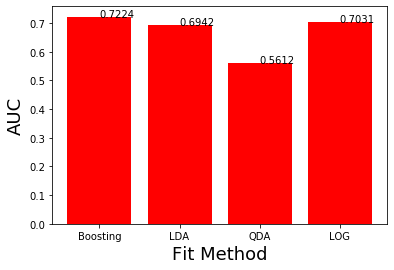

In [16]:
#auc ROC曲线下的面积比较
from sklearn.metrics import roc_auc_score
gb_auc = roc_auc_score(y_test['Purchase[Yes]'],gb_socres)
lda_auc = roc_auc_score(y_test['Purchase[Yes]'],lda_socres)
qda_auc = roc_auc_score(y_test['Purchase[Yes]'],qda_socres)
log_auc = roc_auc_score(y_test['Purchase[Yes]'],log_socres)
method_list = ['Boosting','LDA','QDA','LOG']
auc_list = [gb_auc,lda_auc,qda_auc,log_auc]
plt.bar(method_list,auc_list,color = 'red')
for num in range(len(method_list)):
    plt.text(num,auc_list[num],auc_list[num].round(4))
plt.xlabel("Fit Method", fontsize=18)
plt.ylabel("AUC", fontsize=18)
plt.show()

从AUC上来看实际Boosting方案最好（KNN没有找到输出方法）

In [17]:
#通过曲线比较包括KNN
fpr_pool = [[],[],[],[],[]]
tpr_pool = [[],[],[],[],[]]
for p_thresholds in np.linspace(-0.01,1.01,40):
    method_pool = [gb_clf,lda,qda,grid_search,log]
    for num in range(len(method_pool)):
        y_test_predict = (method_pool[num].predict_proba(X_test) >= p_thresholds)[:,1]            
        fpr_pool[num].append((confusion_matrix(y_test['Purchase[Yes]'],y_test_predict)[0,1])/(y_test['Purchase[No]'].sum()))
        tpr_pool[num].append(recall_score(y_test['Purchase[Yes]'],y_test_predict))

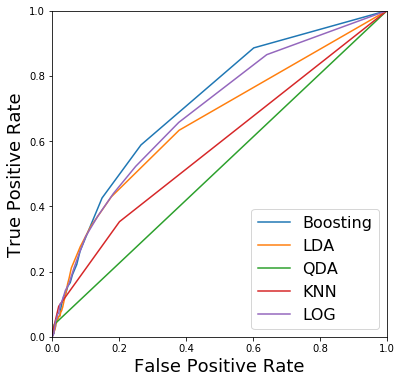

In [18]:
plt.figure(figsize=(6,6))
method_list = ['Boosting','LDA','QDA','KNN','LOG']
for num in range(len(method_list)):
    plt.plot(fpr_pool[num],tpr_pool[num],label = method_list[num])
plt.legend(fontsize=16)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("False Positive Rate", fontsize=18)
plt.ylabel("True Positive Rate", fontsize=18)
plt.show()

从曲线图上看KNN只好于QDA，Boosting最好

**其他：继续尝试对第四章进行变量优化，比较变量优化后的效果**

In [19]:
from sklearn.feature_selection import RFECV
estimator_lda = LinearDiscriminantAnalysis()
estimator_log = LogisticRegression(solver='liblinear')
selector_lda = RFECV(estimator_lda, step=1, cv=10)
selector_log = RFECV(estimator_log, step=1, cv=10)
selector_lda.fit(X_train, y_train['Purchase[Yes]'])
selector_log.fit(X_train, y_train['Purchase[Yes]'])
lda2_predict = (selector_lda.predict_proba(X_test) > 0.2)[:,1]
log2_predict = (selector_log.predict_proba(X_test) > 0.2)[:,1]

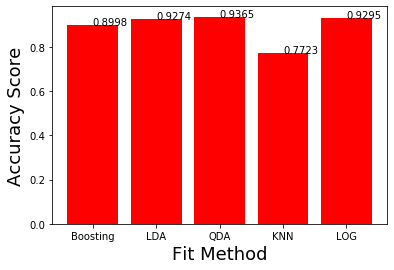

In [20]:
accuracy_gb = accuracy_score(y_test['Purchase[Yes]'],gb_clf_predict)
accuracy_lda = accuracy_score(y_test['Purchase[Yes]'],lda2_predict)
accuracy_qda = accuracy_score(y_test['Purchase[Yes]'],qda_predict)
accuracy_knn = accuracy_score(y_test['Purchase[Yes]'],knn_predict)
accuracy_log = accuracy_score(y_test['Purchase[Yes]'],log2_predict)
method_list = ['Boosting','LDA','QDA','KNN','LOG']
accuracy_list = [accuracy_gb,accuracy_lda,accuracy_qda,accuracy_knn,accuracy_log]
plt.bar(method_list,accuracy_list,color = 'red')
for num in range(len(method_list)):
    plt.text(num,accuracy_list[num],accuracy_list[num].round(4))
plt.xlabel("Fit Method", fontsize=18)
plt.ylabel("Accuracy Score", fontsize=18)
plt.show()

可以看到对LDA及LOG精简变量后，精度有所上升

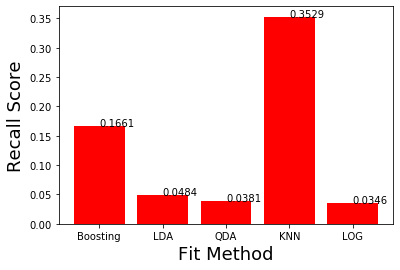

In [21]:
recall_lda = recall_score(y_test['Purchase[Yes]'],lda2_predict)
recall_log = recall_score(y_test['Purchase[Yes]'],log2_predict)
method_list = ['Boosting','LDA','QDA','KNN','LOG']
recall_list = [recall_gb,recall_lda,recall_qda,recall_knn,recall_log]
plt.bar(method_list,recall_list,color = 'red')
for num in range(len(method_list)):
    plt.text(num,recall_list[num],recall_list[num].round(4))
plt.xlabel("Fit Method", fontsize=18)
plt.ylabel("Recall Score", fontsize=18)
plt.show()

召回率下降

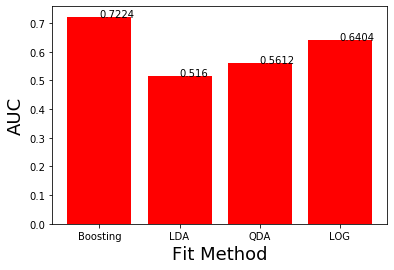

In [22]:
lda_socres = selector_lda.decision_function(X_test)
log_socres = selector_log.decision_function(X_test)
lda_auc = roc_auc_score(y_test['Purchase[Yes]'],lda_socres)
log_auc = roc_auc_score(y_test['Purchase[Yes]'],log_socres)
method_list = ['Boosting','LDA','QDA','LOG']
auc_list = [gb_auc,lda_auc,qda_auc,log_auc]
plt.bar(method_list,auc_list,color = 'red')
for num in range(len(method_list)):
    plt.text(num,auc_list[num],auc_list[num].round(4))
plt.xlabel("Fit Method", fontsize=18)
plt.ylabel("AUC", fontsize=18)
plt.show()

AUC下降（实际REFECV是根据精度进行选择，可能造成AUC的牺牲）

In [23]:
#通过曲线比较包括KNN
fpr_pool = [[],[],[],[],[]]
tpr_pool = [[],[],[],[],[]]
for p_thresholds in np.linspace(-0.01,1.01,40):
    method_pool = [gb_clf,selector_lda,qda,grid_search,selector_log]
    for num in range(len(method_pool)):
        y_test_predict = (method_pool[num].predict_proba(X_test) >= p_thresholds)[:,1]
        fpr_pool[num].append((confusion_matrix(y_test['Purchase[Yes]'],y_test_predict)[0,1])/(y_test['Purchase[No]'].sum()))
        tpr_pool[num].append(recall_score(y_test['Purchase[Yes]'],y_test_predict))

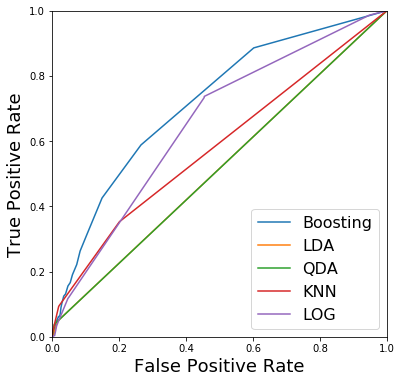

In [24]:
plt.figure(figsize=(6,6))
method_list = ['Boosting','LDA','QDA','KNN','LOG']
for num in range(len(method_list)):
    plt.plot(fpr_pool[num],tpr_pool[num],label = method_list[num])
plt.legend(fontsize=16)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("False Positive Rate", fontsize=18)
plt.ylabel("True Positive Rate", fontsize=18)
plt.show()